In [ ]:
!pip install roboflow
!pip install easyocr
import cv2
import numpy as np

In [ ]:
from roboflow import Roboflow

# Preprocess image with auto-orient, resize, contrast adjustment, and grayscale
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization for contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_equalized = clahe.apply(img_gray)

    # Optionally: Denoise the image to reduce blur
    img_denoised = cv2.fastNlMeansDenoising(img_equalized, h=10, templateWindowSize=7, searchWindowSize=21)

    return img_denoised

# Save the preprocessed image
def save_preprocessed_image(img, output_path):
    cv2.imwrite(output_path, img)

# Initialize Roboflow and load the project
rf = Roboflow(api_key="ZpKbCUOKLeuAO9Ow3I2l")
project = rf.workspace().project("expiry-date-detection-egbf3")
version = project.version(2)
model = version.model

# Define the path to your test image
image_path = "/content/img2.webp"
output_path = "/content/preprocessed_image.webp"

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Save the preprocessed image
save_preprocessed_image(preprocessed_image, output_path)

# Perform inference using the Roboflow model on the preprocessed image
predictions = model.predict(output_path).json()

# Print the predictions (bounding box coordinates and class labels)
print(predictions)

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 321.0, 'y': 118.5, 'width': 78.0, 'height': 67.0, 'confidence': 0.7021122574806213, 'class': 'Label', 'class_id': 0, 'detection_id': '48115f33-bccd-49b1-a7ff-27fea298b1e7', 'image_path': '/content/preprocessed_image.webp', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '390', 'height': '280'}}


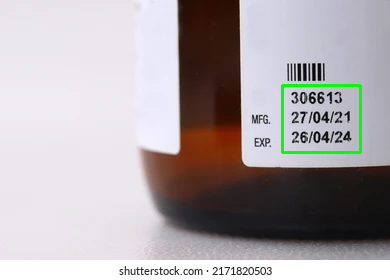

In [ ]:
# Load the original image to draw bounding boxes on
original_image = cv2.imread(image_path)

# Draw bounding boxes on the original image
for prediction in predictions['predictions']:
    x_min = int(prediction['x'] - prediction['width'] / 2)
    y_min = int(prediction['y'] - prediction['height'] / 2)
    x_max = int(prediction['x'] + prediction['width'] / 2)
    y_max = int(prediction['y'] + prediction['height'] / 2)

    # Draw rectangle on the image
    cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green color

# Display the image with bounding boxes
cv2_imshow(original_image)


In [ ]:
# Extract bounding box coordinates from predictions
def extract_bounding_boxes(predictions):
    bounding_boxes = []
    for pred in predictions['predictions']:
        # Each prediction contains bounding box coordinates and class label
        x = pred['x']
        y = pred['y']
        width = pred['width']
        height = pred['height']
        Label = pred['class']  # Class name (should be "label" in your case)

        # Compute bounding box coordinates
        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        bounding_boxes.append((x_min, y_min, x_max, y_max, Label))

    return bounding_boxes

# Extract bounding boxes
bounding_boxes = extract_bounding_boxes(predictions)
print(bounding_boxes)  # Each bounding box: (x_min, y_min, x_max, y_max, label)


[(282, 85, 360, 152, 'Label')]


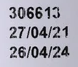

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the original image using OpenCV
image = cv2.imread(image_path)

# Crop the image using bounding box coordinates
def crop_image(image, bbox):
    x_min, y_min, x_max, y_max, label = bbox
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

# Crop and display the images within the bounding boxes
for bbox in bounding_boxes:
    cropped_img = crop_image(image, bbox)
    cv2_imshow(cropped_img)  # Use cv2_imshow instead of cv2.imshow


In [ ]:
import easyocr

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])  # Use 'en' for English language


In [ ]:
# @title For Rechecking OCR text extraction
# Apply OCR to the cropped images and display detected text
def ocr_image(cropped_img):
    result = reader.readtext(cropped_img)
    for (bbox, text, prob) in result:
        print(f"Detected text: {text}, Confidence: {prob}")

# Perform OCR on each cropped image
for bbox in bounding_boxes:
    cropped_img = crop_image(image, bbox)
    ocr_image(cropped_img)


Detected text: 306613, Confidence: 0.999939847195398
Detected text: 27/04/21, Confidence: 0.9997300343402479
Detected text: 26/04/24, Confidence: 0.8225140156581453


In [ ]:
import re
from datetime import datetime

# Function to extract and standardize dates in multiple formats
def extract_dates(text_results):
    dates = []
    confidence_scores = []

    for (bbox, text, prob) in text_results:
        # Regular expression to match various date formats
        date_match = re.search(r'\b(\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4})|(\d{1,2}[\/\-]\d{4})|(\d{1,2} (JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC) \d{2,4})|([A-Z]{3} \d{1,2})|(\d{1,2} [A-Z]{3} \d{2,4})\b', text, re.IGNORECASE)

        if date_match:
            date_text = date_match.group(0)

            # Normalize two-digit year to four-digit
            if len(date_text.split('/')[-1]) == 2:
                date_text = date_text[:-2] + '20' + date_text[-2:]

            try:
                # Try parsing as dd/mm/yyyy
                parsed_date = datetime.strptime(date_text, '%d/%m/%Y')
            except ValueError:
                try:
                    # Try parsing as mm/yyyy
                    parsed_date = datetime.strptime(date_text, '%m/%Y')
                    # Set the day to the first of the month for consistency
                    parsed_date = parsed_date.replace(day=1)
                except ValueError:
                    try:
                        # Try parsing as d MMM yyyy (e.g., 4 MAR 2024)
                        parsed_date = datetime.strptime(date_text, '%d %b %Y')
                    except ValueError:
                        try:
                            # Try parsing as MMM YY (e.g., JUL 26)
                            parsed_date = datetime.strptime(date_text, '%b %y')
                            # Set the day to the first of the month for consistency
                            parsed_date = parsed_date.replace(day=1)
                        except ValueError:
                            try:
                                # Try parsing as d MMM YY (e.g., 04 MAR 204)
                                parsed_date = datetime.strptime(date_text, '%d %b %y')
                            except ValueError:
                                continue

            # Convert date to dd/mm/yyyy format
            standardized_date = parsed_date.strftime('%d/%m/%Y')
            dates.append(standardized_date)
            confidence_scores.append(prob)

    return dates, confidence_scores


# Function to extract MRP and its confidence
def extract_mrp(text_results):
    mrp_value = "none"  # Default if MRP is not detected
    confidence_score = 0  # Default confidence if MRP is not detected
    for (bbox, text, prob) in text_results:
        # Check if the text contains "MRP" followed by a price
        mrp_match = re.search(r'MRP[^\d]*(\d+\.?\d*)', text)
        if mrp_match:
            mrp_value = mrp_match.group(1)
            confidence_score = prob  # Update confidence score if MRP is detected
    return mrp_value, confidence_score

# Function to display Manufacturing Date, Expiry Date, and MRP with confidence
def display_info(text_results):
    # Extract dates and MRP from the OCR output
    dates, date_confidences = extract_dates(text_results)
    mrp, mrp_confidence = extract_mrp(text_results)

    # Determine manufacturing and expiry dates
    if len(dates) >= 2:
        manufacturing_date = dates[0]  # Assuming the first date is MFD
        expiry_date = dates[1]  # Assuming the second date is EXP
        manufacturing_confidence = date_confidences[0]  # Assuming confidence corresponds
        expiry_confidence = date_confidences[1]
    elif len(dates) == 1:
        manufacturing_date = dates[0]
        expiry_date = "Not detected"
        manufacturing_confidence = date_confidences[0]
        expiry_confidence = "N/A"
    else:
        manufacturing_date = "Not detected"
        expiry_date = "Not detected"
        manufacturing_confidence = "N/A"
        expiry_confidence = "N/A"

    # Display the extracted information with confidence
    print(f"Manufacturing Date: {manufacturing_date} (Confidence: {manufacturing_confidence})")
    print(f"Expiry Date: {expiry_date} (Confidence: {expiry_confidence})")
    print(f"MRP: {mrp} (Confidence: {mrp_confidence})")

# Function to apply OCR on each cropped image and display detected text
def ocr_image(cropped_img):
    result = reader.readtext(cropped_img)

    # Extract and display only the required information (dates and MRP)
    display_info(result)

# Example usage with bounding boxes
for bbox in bounding_boxes:
    cropped_img = crop_image(image, bbox)
    ocr_image(cropped_img)


Manufacturing Date: 27/04/2021 (Confidence: 0.9997300343402479)
Expiry Date: 26/04/2024 (Confidence: 0.8225140156581453)
MRP: none (Confidence: 0)


 .
